# Session 3

# Regression Diagnostics

In [5]:
# Load relevant libraries.

%pylab inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#import Quandl
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.api import abline_plot
import patsy
import seaborn as sns
sns.set(context='notebook', style='whitegrid', palette='deep', font='sans-serif', font_scale=1, rc=None)
import urllib2 as url

Populating the interactive namespace from numpy and matplotlib


In [6]:
# One more time.
'''
aapl_all = Quandl.get("YAHOO/AAPL", trim_start="2010-1-1", trim_end="2015-09-18")
nasdaq_all = Quandl.get("NASDAQOMX/COMP", trim_start="2010-1-1", trim_end="2015-09-18")
aapl = aapl_all['Adjusted Close']
nasdaq = nasdaq_all['Index Value']
aapl_returns = np.log(aapl / aapl.shift(1))
nasdaq_returns = np.log(nasdaq / nasdaq.shift(1))
aapl_returns = aapl_returns.dropna()
nasdaq_returns = nasdaq_returns.dropna()
aapl_returns = pd.DataFrame(aapl_returns)
nasdaq_returns = pd.DataFrame(nasdaq_returns)
data = pd.merge(nasdaq_returns, aapl_returns, left_index=True, right_index=True)
data.rename(columns={'Index Value':'nasdaq', 'Adjusted Close':'aapl'}, inplace=True)
mod = smf.ols(formula='aapl ~ nasdaq', data = data).fit()
print(mod.summary())
'''

'\naapl_all = Quandl.get("YAHOO/AAPL", trim_start="2010-1-1", trim_end="2015-09-18")\nnasdaq_all = Quandl.get("NASDAQOMX/COMP", trim_start="2010-1-1", trim_end="2015-09-18")\naapl = aapl_all[\'Adjusted Close\']\nnasdaq = nasdaq_all[\'Index Value\']\naapl_returns = np.log(aapl / aapl.shift(1))\nnasdaq_returns = np.log(nasdaq / nasdaq.shift(1))\naapl_returns = aapl_returns.dropna()\nnasdaq_returns = nasdaq_returns.dropna()\naapl_returns = pd.DataFrame(aapl_returns)\nnasdaq_returns = pd.DataFrame(nasdaq_returns)\ndata = pd.merge(nasdaq_returns, aapl_returns, left_index=True, right_index=True)\ndata.rename(columns={\'Index Value\':\'nasdaq\', \'Adjusted Close\':\'aapl\'}, inplace=True)\nmod = smf.ols(formula=\'aapl ~ nasdaq\', data = data).fit()\nprint(mod.summary())\n'

## R$^2$

We already know that different packages produce different regression output, which are typically called "regression diagnosgics."  Python's statsmodels basically mirrors the regression diagnostics produced by Stata.  We have already reviewed coefficients, standard errors, t values, and confidence intervals. 

As I noted, the R$^2$ "goodness of fit" metric is a frequently-cited regression diagnostic.  If a linear regression uses a constant (which should be included in practice), the R$^2$ is bounded between 0 and 1.  It measures the share of the variation in $y$ explained by the variation in the features used in a model.  Given this definition, "bigger is better" is the first place that people go to evaluate the quality of the model, which is unwarranted.  

"However, it can still be challenging to determine what is a good R$^2$ value, and in general, this will depend on the application.  For instance, in certain problems in physics, we may know that the data truly comes from a linear model with a small residual error.  In this case, we would expect to see an R$^2$ value that is extremely close to 1, and a substantially smaller R$^2$ might indicate serious problems with the experiment in which the data were generated.  On the other hand, in typical application in biology, pyschology, marketing and other domains, the linear model is at best an extremely rough approximation to the data, and residual errors due to other unmeasured factors are often very large.  In this setting, we would expect only a very small proportion of the variacne in the response to be explained by the predictor, and an R$^2$ value well below 0.1 might be more realistic."  Trevor Hastie, Robert Tibshirani, et al.

The example I showed last time was meant to highlight this very point.  

## Other Diagnostics to Assess Model Quality

Adjusted R$^2$: A metric that captures the penalty in the use of a large number of features with little explanatory power.  

AIC (the Akaike Information Criterion): a measure of the relative quality of a statistical model for a given set of data.  It captures the trade-off between the goodness of fit and the complexity of the model.  For example, if I have $N$ $(y,x)$ pairs, I could in principle fit an $N-1$ degree polynomial that passed through all points.  

BIC (the Bayes Information Criterion): another measure of relative quality.  Rule of thumb: chose the model with the lowest BIC.

# Multivariate Regression Analysis

It is trivial to extend the single-feature linear model to a linear model that simultaneously incorporates multiple features.  The interpretation of the results of a statistical model that uses multiple features is the same the interpretation of the partial derivative from the calculus of many variables: the effect of a small change in a particular feature on a label (or outcome).  

A model with $K$ features, $x_{ik}$ and label $y_i$:

$y_i=\sum_{k=1}^Kx_{ik}\cdot\beta_k+\epsilon_i = x_i^\prime \beta + \epsilon_i$

The $K$ features $x_{ik}$ influence the label $y_i$ through the $K$-vector, $\beta$, which we estimate statistically.  A specific partial derivative interpretation.

${\displaystyle \frac{\partial E(y_i)}{\partial x_{ik}}=\beta_k}$

(For those interested in ancient history: Frisch–Waugh–Lovell theorem.)

Bottom line is simple: Fit the linear model with multiple features.  The basic approach to hypothesis testing remains unchanged. The challenge is the interpretation of the results, which we will discuss in detail.  

In [8]:
# Load data: Property sales records of single-family, owner-occupied houses in Staten Island between 2003 and early 2013.  
# See https://app.enigma.io/table/us.states.ny.cities.nyc.property.annualized-sales?row=0&col=0&page=1&documentView=false
# Often times lacking the convenience of an API, 
# it may be necessary to load data that has been formatted using other statistical learning environments.
# Python's pandas allows us to do so in Python.
# R's foreign library allow us to do so in R.

sales = pd.read_stata('SI Sales Old.dta')

In [9]:
# DATA DICTIONARY
# price: Sales price in $
# unit_size: Size of dwelling in square meters
# land_size: Size of land on which dwelling sits in square meters
# age: Age of dwelling in years at sale
# todt: Indicator (or dummy variable) of whether a dwelling is in Todt Hill, Staten Island
# sales_year: Year of sale
 
print sales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31680 entries, 0 to 31679
Data columns (total 6 columns):
price         31680 non-null float64
unit_size     31680 non-null float32
land_size     31680 non-null float32
age           31680 non-null float32
todt          31680 non-null float32
sales_year    31680 non-null float32
dtypes: float32(5), float64(1)
memory usage: 1.1 MB
None


In [10]:
# Summary Statistics
# Note that I have cleaned the data for "outliers" (outside of the scope of this class).

print sales.describe()

                price     unit_size     land_size           age          todt  \
count    31680.000000  31680.000000  31680.000000  31680.000000  31680.000000   
mean    402106.300221    161.038952    326.063384     35.846843      0.007102   
std     239551.524308     79.404530    289.825501     31.082471      0.083968   
min      50500.000000     20.067047     24.340586      0.000000      0.000000   
25%     291975.000000    114.456497    185.806000      9.000000      0.000000   
50%     371000.000000    145.671906    252.696167     27.000000      0.000000   
75%     455000.000000    184.969879    380.902313     56.000000      0.000000   
max    7700000.000000   1431.077759  10788.825195    119.000000      1.000000   

         sales_year  
count  31680.000000  
mean    2006.567172  
std        2.766369  
min     2003.000000  
25%     2004.000000  
50%     2006.000000  
75%     2009.000000  
max     2013.000000  


In [11]:
# Let's examine the correlation matrix.

print sales.corr()

               price  unit_size  land_size       age      todt  sales_year
price       1.000000   0.549706   0.505356 -0.064088  0.352151    0.096092
unit_size   0.549706   1.000000   0.446105 -0.201536  0.326307    0.023416
land_size   0.505356   0.446105   1.000000  0.274697  0.346801    0.077402
age        -0.064088  -0.201536   0.274697  1.000000  0.005157    0.125040
todt        0.352151   0.326307   0.346801  0.005157  1.000000    0.012260
sales_year  0.096092   0.023416   0.077402  0.125040  0.012260    1.000000


In [12]:
# Start with bivariate linear model that explains the variation in sales prices by the size of the dwelling.

mod = smf.ols(formula='price ~ unit_size', data = sales).fit()
print(mod.summary())

# How to intepret these results?  For every additional square meter of dwelling size, sales price is ~$1,658 higher.
# The 95% Confidence Interval of this effect is [1630, 1686].
# Average unit size is 161 square meters, with a standard deviation of 79 square meters.  
# Therefore, an increase of one standard deviation in dwelling size would increase the sales price by 79 * $1,656 = $130,824.

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.302
Model:                            OLS   Adj. R-squared:                  0.302
Method:                 Least Squares   F-statistic:                 1.372e+04
Date:                Mon, 28 Sep 2015   Prob (F-statistic):               0.00
Time:                        18:20:25   Log-Likelihood:            -4.3166e+05
No. Observations:               31680   AIC:                         8.633e+05
Df Residuals:                   31678   BIC:                         8.633e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept    1.35e+05   2542.335     53.118      0.0

In [13]:
# Alternative table layout.

mod.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                    Results: Ordinary least squares
=======================================================================
Model:               OLS               Adj. R-squared:      0.302      
Dependent Variable:  price             AIC:                 863318.9733
Date:                2015-09-28 18:25  BIC:                 863335.7002
No. Observations:    31680             Log-Likelihood:      -4.3166e+05
Df Model:            1                 F-statistic:         1.372e+04  
Df Residuals:        31678             Prob (F-statistic):  0.00       
R-squared:           0.302             Scale:               4.0046e+10 
-----------------------------------------------------------------------
             Coef.     Std.Err.    t     P>|t|     [0.025      0.975]  
-----------------------------------------------------------------------
Intercept 135043.8679 2542.3346  53.1181 0.0000 130060.7932 140026.9425
unit_size   1658.3706   14.1594 117.1215 0.0000   1630.6176   1686.1236
-----------------------------------------------------------------------
Omnibus:            51914.230      Durbin-Watson:         1.973        
Prob(Omnibus):      0.000          Jarque-Bera (JB):      103733692.864
Skew:               10.534         Prob(JB):              0.000        
Kurtosis:           282.539        Condition No.:         406          
=======================================================================

"""

In [14]:
# Perhaps we believe that more than one feature can simultaneously affect sales prices.
# We can easily use multivariate regression to account for many features at once.
# When we add an additional feature, namely the land size, we find that it has an independent effect.
# Holding constant unit_size, an increase in land_size of one square meter independently increases the sales price by $268.
# In addition, note that the effect of unit size on price has fallen from $1,658 to $1,221.
# Moreover, the 95% Confidence Intervals do not overlap.
# This is evidence of omitted variable bias (sometimes called the "collinearity problem").  
# Failing to include land_size has biased up the measured effect of unit_size because the two features are positively correlated.
# The two features, however, have independent effects on sales prices.
# In this example, we can compare the R-squared measures across the two models because one is nested in the other.  
# We see that the R-squared rises from 0.302 to 0.387, indicating a considerable improvement in the fit of the data.

mod = smf.ols(formula='price ~ unit_size + land_size', data = sales).fit()
print(mod.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.387
Model:                            OLS   Adj. R-squared:                  0.387
Method:                 Least Squares   F-statistic:                     9985.
Date:                Mon, 28 Sep 2015   Prob (F-statistic):               0.00
Time:                        18:29:03   Log-Likelihood:            -4.2961e+05
No. Observations:               31680   AIC:                         8.592e+05
Df Residuals:                   31677   BIC:                         8.593e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   1.179e+05   2397.598     49.177      0.0

In [15]:
# Now let's examine what happens when we account for the age of the dwelling at the date of sale.
# Thoughts about how age might affect sales prices?
# Negative impact: old houses (of equal size) how lower sales prices.
# Note, however, that there is little impact on the effects of the other features when we add age to the model.

mod = smf.ols(formula='price ~ unit_size + land_size + age', data = sales).fit()
print(mod.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.393
Model:                            OLS   Adj. R-squared:                  0.393
Method:                 Least Squares   F-statistic:                     6840.
Date:                Mon, 28 Sep 2015   Prob (F-statistic):               0.00
Time:                        18:34:14   Log-Likelihood:            -4.2945e+05
No. Observations:               31680   AIC:                         8.589e+05
Df Residuals:                   31676   BIC:                         8.589e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   1.496e+05   2940.848     50.854      0.0

In [16]:
# This is an example of using dummy or indicator variables to capture potential "discontinuities" in our model.
# I am told that by people at CUSP that Todt Hill is an upscale area in Staten Island.
# Suppose we want to capture this feature of the data, which we can do using the indicator "todt". 

mod = smf.ols(formula='price ~ unit_size + land_size + age + todt', data = sales).fit()
print(mod.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.406
Model:                            OLS   Adj. R-squared:                  0.406
Method:                 Least Squares   F-statistic:                     5421.
Date:                Mon, 28 Sep 2015   Prob (F-statistic):               0.00
Time:                        18:35:17   Log-Likelihood:            -4.2910e+05
No. Observations:               31680   AIC:                         8.582e+05
Df Residuals:                   31675   BIC:                         8.582e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   1.674e+05   2985.210     56.076      0.0

In [17]:
# Scaling of data.  
# Suppose we wanted to rescale the sales prices because they are measured in $ (and are large).
# Rescale the label by dividing by 1000.

sales['priceper1000'] = sales['price']/1000
print sales.head()

    price   unit_size   land_size  age  todt  sales_year  priceper1000
0  327500  142.699005  232.257507   32     0        2011       327.500
1  346314  195.096298  239.318130   10     0        2006       346.314
2  349830  179.488602  201.413712    1     0        2006       349.830
3  325000  174.750549  227.612350  106     0        2005       325.000
4  285000   97.083633  271.741272  104     0        2003       285.000


In [18]:
# How does this rescaling affect our estimates?

mod = smf.ols(formula='priceper1000 ~ unit_size + land_size + age + todt', data = sales).fit()
print(mod.summary())
#sm.stats.sandwich_covariance.cov_hc0(mod)

                            OLS Regression Results                            
Dep. Variable:           priceper1000   R-squared:                       0.406
Model:                            OLS   Adj. R-squared:                  0.406
Method:                 Least Squares   F-statistic:                     5421.
Date:                Mon, 28 Sep 2015   Prob (F-statistic):               0.00
Time:                        18:37:27   Log-Likelihood:            -2.1026e+05
No. Observations:               31680   AIC:                         4.205e+05
Df Residuals:                   31675   BIC:                         4.206e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept    167.3977      2.985     56.076      0.0

In [30]:
# It may be more relevant to consider this in terms of percent changes in values.  
# For example, what is the percentage rate of change in sales prices given a percent change in unit size.
# In economics, these are elasticities, which are unit-free measures.

sales['logprice'] = np.log(sales['price'])
sales['logunit'] = np.log(sales['unit_size'])
sales['logland'] = np.log(sales['land_size']+1)
sales['logage'] = np.log(sales['age']+1)

In [31]:
# A 10% change in unit size increases sales price by 3.4%.
# A 10% change in land size increases sales price by 2.6%.
# A 10% change in age decreases sales prices by 0.5%.
# Prices in Todt Hill are about 44% higher holding all else constant.
# Is this model directly comparable to the one above?
# No because we non-linearly transformed both the label and the features.

mod = smf.ols(formula='logprice ~ logunit + logland + logage + todt', data = sales).fit()
print(mod.summary())

                            OLS Regression Results                            
Dep. Variable:               logprice   R-squared:                       0.365
Model:                            OLS   Adj. R-squared:                  0.364
Method:                 Least Squares   F-statistic:                     4542.
Date:                Mon, 28 Sep 2015   Prob (F-statistic):               0.00
Time:                        19:18:25   Log-Likelihood:                -12509.
No. Observations:               31680   AIC:                         2.503e+04
Df Residuals:                   31675   BIC:                         2.507e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      9.7682      0.029    331.851      0.0

# The Linear Probability Model and The Logistic Classifier (or "Logit")

The problem above examined a continuous label or dependent variable.  That is, $y$ was quantitative: the sales prices of single-family houses in Staten Island.  Often, we wish to examine a discrete or categorical label.  What is a categorical label?  An example would be eye color: $\{$brown, green, blue$\}$.  

In economics, this is considered to be analysis of "limited dependent variables," while in computer science, it is classification.  This different terminology refers to the same thing.  We will begin with the linear probability model (with multiple attributes), which allows us to seemless transition to the Logistic Classifier (or "Logit").

This simple classifier is the ground upon which data scientists of all stripes converge.  It is a very important methodological technique that I want you to understand thoroughly.

## Latent Values

One can think of categorical variable as being driven by an underlying DGP, and we as observers, observe only outcomes.

Consider: $y_i^*=x_i^\prime\beta+\epsilon_i$

$y_i^*$ is a latent value for person i that is unobserved by us.  For example, you do not observe the value I place on this bottle of water.  You simple observe me drinking it.  In other words, you observe the outcome my choice set $\{$drink, not drink$\}$.  Another example would be observing someone taking a taxi.  You do not observe the value that someone places on the taxi ride.  You know that she has many alternative methods of transportation, all with varying values to her, but you observe the outcome of her choice.

$x_i$ are a vector of features (or attributes or predictors or independent variables).  We observe these.

$\beta$ is a vector that measures how features affect the latent index, which we will estimate statistically. 

$\epsilon_i$ retains its status as our ignorance.  

What do we observe?

${\displaystyle d_i = }$
$\left\{ \begin{array}{l l} 
{1} & \quad \text{if person i takes a cab, which happens when } y_i^*\ge0\\ 
{0} & \quad \text{if person i does not take a cab, which happens when } y_i^*\lt0 \\
\end{array} \right.$

The latent variable approach has become a very popular modeling tool in statistical learning.  

In [59]:
# Read in some data on graduate school admissions.  These data are fictional, but useful.

#data = pd.read_csv("http://www.ats.ucla.edu/stat/data/binary.csv")
data['rank'][data['rank']==4] = 3
print data.info()
print data.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400 entries, 0 to 399
Data columns (total 4 columns):
admit    400 non-null int64
gre      400 non-null int64
gpa      400 non-null float64
rank     400 non-null int64
dtypes: float64(1), int64(3)
memory usage: 15.6 KB
None
            admit         gre         gpa        rank
count  400.000000  400.000000  400.000000  400.000000
mean     0.317500  587.700000    3.389900    2.317500
std      0.466087  115.516536    0.380567    0.723188
min      0.000000  220.000000    2.260000    1.000000
25%      0.000000  520.000000    3.130000    2.000000
50%      0.000000  580.000000    3.395000    2.000000
75%      1.000000  660.000000    3.670000    3.000000
max      1.000000  800.000000    4.000000    3.000000


C:\Users\Jeremy\Anaconda\lib\site-packages\IPython\kernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## Lab Session

Find the correlation matrix between the variables.
Run a few linear models.

In [33]:
print data.corr()

          admit       gre       gpa      rank
admit  1.000000  0.184434  0.178212 -0.242513
gre    0.184434  1.000000  0.384266 -0.123447
gpa    0.178212  0.384266  1.000000 -0.057461
rank  -0.242513 -0.123447 -0.057461  1.000000


In [60]:
# School rank is a categorical feature, and we should capture this aspect using C(rank)
# C(rank) tells statsmodels to convert the categorical variable into indicator variables and omit one of them
# The omitted categorical indicator is the reference category.
# Let's interpret the results from the linear probability model using the summary statistics from the data.
# GRE: Graduate Record Examine: a one point increase in GRE increases probability of admission by 0.0004 or 0.04%
# GPA: Grade Point Average: a one point increase in GPA increases probability of admission by 0.156 or 15.6%.  
# rank: Going to a tier 2 school reduces probabilty of admission by 0.1624 or 16.24% (relative to a tier 1 school).

mod = smf.ols(formula='admit ~ gre + gpa + C(rank)', data = data).fit()
print(mod.summary())
#print data.describe()

                            OLS Regression Results                            
Dep. Variable:                  admit   R-squared:                       0.100
Model:                            OLS   Adj. R-squared:                  0.091
Method:                 Least Squares   F-statistic:                     10.96
Date:                Mon, 28 Sep 2015   Prob (F-statistic):           1.95e-08
Time:                        20:19:45   Log-Likelihood:                -240.68
No. Observations:                 400   AIC:                             491.4
Df Residuals:                     395   BIC:                             511.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
Intercept       -0.2680      0.215     -1.247   

In [44]:
# Let's make a prediction of admission for the "average" applicant at a tier 2 school.
# How might we generate a 95% confidence interval on this prediction?  You did it in Homework 2.  It's called bootstrapping.
# Remember the prediction for later.

print data.describe()
print 
print mod.params
print
print (mod.params['Intercept'] + mod.params['C(rank)[T.2]'] + mod.params['gre'] *587.7 + mod.params['gpa'] * 3.3899)

            admit         gre         gpa       rank
count  400.000000  400.000000  400.000000  400.00000
mean     0.317500  587.700000    3.389900    2.48500
std      0.466087  115.516536    0.380567    0.94446
min      0.000000  220.000000    2.260000    1.00000
25%      0.000000  520.000000    3.130000    2.00000
50%      0.000000  580.000000    3.395000    2.00000
75%      1.000000  660.000000    3.670000    3.00000
max      1.000000  800.000000    4.000000    4.00000

Intercept      -0.258910
C(rank)[T.2]   -0.162365
C(rank)[T.3]   -0.290570
C(rank)[T.4]   -0.323026
gre             0.000430
gpa             0.155535
dtype: float64

0.358432056382


## The Logistic Classifier

We are going to change the linear model to the following:

$Pr(d_i=1)=x_i^\prime\beta+\epsilon_i$

We will then impose a distributional assumption on $\epsilon_i$, namely that it is logistically distributed.

${\displaystyle Pr(d_i=1) = \frac{\exp(x_i^\prime\beta)}{1+\exp(x_i^\prime\beta)}}$ 

We see immediately that this is NOT a linear model (that is, a model that is linear in $\beta$).

${\displaystyle Pr(d_i=0) = 1 - Pr(d_i=1) = 1 - \frac{\exp(x_i^\prime\beta)}{1+\exp(x_i^\prime\beta)} = \frac{1}{1+\exp(x_i^\prime\beta)}}$

An "odds ratio":

${\displaystyle \frac{Pr(d_i=1)}{Pr(d_i=0)} = \frac{Pr(d_i=1)}{1 - Pr(d_i=1)} = \exp(x_i^\prime\beta)}$

This implies that the log-odds ratio (or "logit") is:

${\displaystyle \log\big(\frac{Pr(d_i=1)}{1 - Pr(d_i=1)}\big) = x_i^\prime\beta}$, which is linear in $\beta$.

To address the estimation of the parameters of interest, we need to construct a likelihood function that we will tell the computer to optimize.  Start by constructing the likelihood for observation $i$:

${\displaystyle l_i = Pr(d_i=1)^{d_i}\cdot Pr(d_i=0)^{(1-d_i)}=\frac{\exp(x_i^\prime\beta)}{1+\exp(x_i^\prime\beta)}^{d_1}\frac{1}{1+\exp(x_i^\prime\beta)}^{(1-d_i)}}$

If we make some assumptions we can write:

${\displaystyle L = \prod_{i=1}^N l_i = \prod_{i=1}^N \frac{\exp(x_i^\prime\beta)}{1+\exp(x_i^\prime\beta)}^{d_1}\frac{1}{1+\exp(x_i^\prime\beta)}^{(1-d_i)}}$

Goal is to tell the computer to maximize $L$ with respect to $\beta$ given the data we have. 

Once we have done that, we can make probabilistic predictions (or classifications).

In [ ]:
# Let's fit the logit.

logit_mod = smf.logit('admit ~ gre + gpa + C(rank)', data = data).fit()
print
print(logit_mod.summary())

What are these logit coefficients?
Big lesson: Unlike the linear probability model, shown below, they cannot be directly interpreted.
Note, however, the similarities.  

1. The signs are identical.
2. The relative magnitudes are similar.
3. The z and the t are (relatively) similar.

In [ ]:
print(mod.summary())

In [ ]:
# Again we can make a prediction, the probability of admission or Pr(d=1), 
# using the logistic formula above.
# Average features at rank 2 school.

print data.describe()
print 
print logit_mod.params
print
e = np.exp(logit_mod.params['Intercept'] + logit_mod.params['C(rank)[T.2]'] + 
           logit_mod.params['gre'] *587.7 + logit_mod.params['gpa'] * 3.3899)
print(e / (1 + e))

In [ ]:
# We can also generate marginal effects, 
# which are the change in probability of admission given a "small" change in the features. 
# Note their similarilities to the regression estimates from the linear probability model.

marginal = logit_mod.get_margeff()
print(marginal.summary())
print
print mod.params

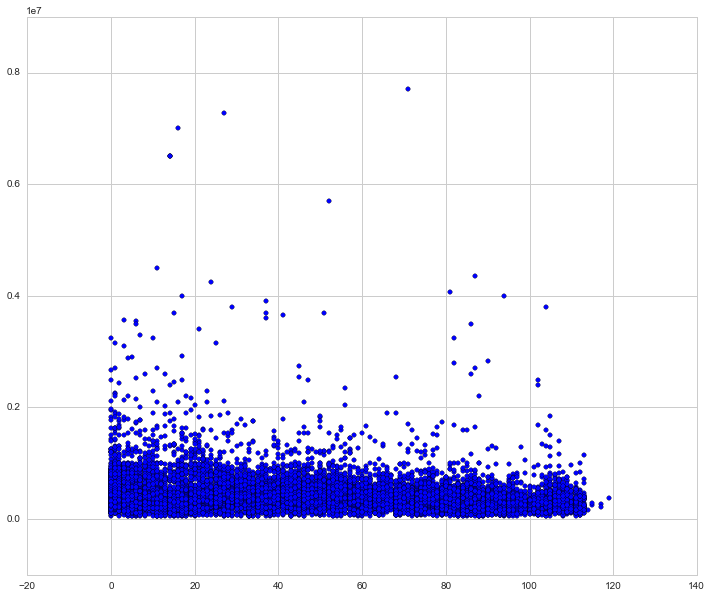

In [21]:
figure, ax = plt.subplots(figsize=(12,10))
ax.scatter(sales['age'],sales['price'])

In [25]:
sales['age2'] = sales['age']**2
mod = smf.ols(formula='price ~ unit_size + land_size + age2 + todt', data = sales).fit()
print(mod.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.409
Model:                            OLS   Adj. R-squared:                  0.409
Method:                 Least Squares   F-statistic:                     5479.
Date:                Mon, 28 Sep 2015   Prob (F-statistic):               0.00
Time:                        18:56:28   Log-Likelihood:            -4.2903e+05
No. Observations:               31680   AIC:                         8.581e+05
Df Residuals:                   31675   BIC:                         8.581e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   1.604e+05   2685.491     59.714      0.0